<a href="https://colab.research.google.com/github/lindermanlab/hackathons/blob/master/Random_Walk_MH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding with Random-Walk Metropolis-Hasting

Suppose we are designing a random walk Metropolis-Hastings algorithm to sample a target distribution.  What variance should we give to our proposal distribution?

To understand this better, let's consider a simple multivariate Gaussian example.  Our target is the standard Normal,
\begin{align}
p(x) &= \mathcal{N}(0, I),
\end{align}
and our Metropolis-Hastings proposal is another spherical Gaussian parameterized by a variance $\sigma^2$,
\begin{align}
q(x' \mid x) &= \mathcal{N}(x, \sigma^2 I).
\end{align}
Obviously this is _not_ a problem where you would invoke MCMC, but it's still a useful toy problem for thinking about how to set $\sigma^2$ in order to optimize the Markov chain.

Specifically, suppose we want to approximate the expectation $\mathbb{E}_p[f(x)]$ with Markov chain Monte Carlo estimate,
\begin{align}
\hat{f}_N &= \frac{1}{N} \sum_{n=1}^N f(X_n) \\
X_1 &\sim p \\
X_n \mid X_{n-1} &\sim T(\cdot \mid X_{n-1})
\end{align}
where
\begin{align}
p_{T}(x_n \mid x_{n-1}) &= q(x_n \mid x_{n-1}) \cdot a(x_n \mid x_{n-1}),
\end{align}
where $a$ denotes the probability of accepting a move from $X_{n-1} = x_{n-1}$ to $X_n = x_n$.

For this model, the acceptance probability is,
\begin{align}
a(x_n \mid x_{n-1}) 
&= \min \left( 1, \frac{p(x_n)q(x_{n-1} \mid x_n)}{p(x_{n-1}) q(x_n \mid x_{n-1})} \right) \\
&= \min \left( 1, \frac{\mathcal{N}(x_n; 0, I)) \mathcal{N}(x_{n-1} \mid x_n, \sigma^2 I)}{\mathcal{N}(x_{n-1}; 0, I) \mathcal{N}(x_n \mid x_{n-1}, \sigma^2 I)} \right) \\
&= \min \left( 1, \frac{\mathcal{N}(x_n; 0, I)}{\mathcal{N}(x_{n-1}; 0, I)} \right) \\
&= \min \left( 1, \frac{\exp \{-\frac{1}{2} x_n^\top x_n \}}{\exp \{-\frac{1}{2} x_{n-1}^\top x_{n-1} \} } \right) \\
&= \min \left( 1, \exp \{-\tfrac{1}{2} (x_n^\top x_n - x_{n-1}^\top x_{n-1}) \} \right) \\
&= \min \left( 1, \exp \{-\tfrac{1}{2} (\|x_n\|_2^2 - \|x_{n-1}\|_2^2) \} \right)
\end{align}
So we always accept proposals if $\|x_n\|_2^2 - \|x_{n-1}\|_2^2 < 0$.  The physical intuition is to recognize $\|x_n\|_2^2$ as the _energy_ of the system, so we always accept moves that decrease the energy, but we only sometimes accept moves that increase it.  The acceptance probability is proportional to the exponentiated change in energy.

As we discuss below, we want to tune $\sigma^2$ such that the samples of this Markov chain yield the lowest variance estimates of some expectation of interest. 

In [33]:
!pip install tfp-nightly

     |████████████████████████████████| 4.5MB 2.7MB/s 


In [7]:
import jax.numpy as np
import jax.random
from jax import lax, jit
from functools import partial
import tensorflow_probability.substrates.jax.distributions as dists
import matplotlib.pyplot as plt

In [45]:
def _run_mcmc(rng, proposal_variance, num_steps=100, dim=2):
    """
    Run the random walk MH algorithm with specified random key,
    proposal variance, number of MCMC steps, and problem dimensionality.
    """
    # first sample initial distribution
    p = dists.MultivariateNormalDiag(loc=np.zeros(dim), 
                                     scale_diag=np.ones(dim))
    
    # Sample initial condition
    rngs = jax.random.split(rng, num_steps)
    x0 = p.sample(seed=rngs[0])

    # Define the for loop body
    def update(x, rng):
        # the loop carries around a sample value and a rng
        x_rng, u_rng = jax.random.split(rng, 2)

        # propose a new x value
        q = dists.MultivariateNormalDiag(
            loc=x, scale_diag=np.sqrt(proposal_variance) * np.ones(dim))
        x_prop = q.sample(seed=x_rng)

        # - evaluate acceptance probability
        log_accept_prob = p.log_prob(x_prop) - p.log_prob(x)
        
        # - randomly accept/reject, update x as necessary
        u = jax.random.uniform(u_rng)
        x = lax.cond(np.log(u) < log_accept_prob,
                     lambda operand: x_prop,
                     lambda operand: x,
                     None)
        
        return x, x 

    _, xs = lax.scan(update, x0, rngs[1:])
    return xs

run_mcmc = jit(_run_mcmc, static_argnums=(2, 3))

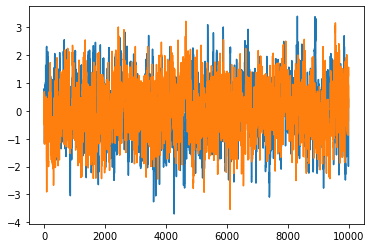

In [47]:
# Try it out!
xs = run_mcmc(jax.random.PRNGKey(0), 0.5**2, 10000, 2)
plt.plot(xs)

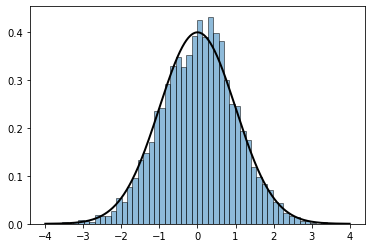

In [48]:
# Make sure the marginals are standard normals
xgrid = np.linspace(-4, 4, 1000)
plt.hist(xs[:, 0], 50, density=True, alpha=0.5, edgecolor='k')
plt.plot(xgrid, dists.Normal(0, 1).prob(xgrid), '-k', lw=2)

# Compare variance of MCMC estimators as a function of $\sigma^2$
The quantity that we wish to minimize is
\begin{align}
\mathrm{Var}[\hat{f}_N].
\end{align}

**Experiment**
- pick some $f$, e.g. $f(x) = x$
- repeat $M$ times: run MCMC for $N$ steps from random initial condition, and evaluate $\hat{f}_N^{(m)}$. 
- compute variance of estimates $\{\hat{f}_N^{(m)}\}_{m=1}^M$


In [58]:
def mcmc_experiment(rng, f, var, num_chains, num_steps, dim=2):
    f_hats = []
    for i in range(num_chains):
        rng, this_rng = jax.random.split(rng, 2)
        xs = run_mcmc(this_rng, var, num_steps, dim)
        f_hat = np.mean(f(xs))
        f_hats.append(f_hat)
    return np.array(f_hats).var(), f_hats

In [79]:
f = lambda x: np.sum(x, axis=1)
proposal_variances = np.array([0.1**2, 0.25**2, 0.5**2, 0.9**2, 1.0, 
                               1.1**2, 1.25**2, 1.5**2, 2.**2, 3.**2, 
                               5.**2, 10.**2])
num_chains = 1000
num_steps = 1000
estimator_variances = []
for proposal_variance in proposal_variances:
    print("Proposal variance ", proposal_variance)
    var_f_hat, f_hats = mcmc_experiment(jax.random.PRNGKey(0),
                                        f, proposal_variance, 
                                        num_chains, 
                                        num_steps)
    
    estimator_variances.append(var_f_hat)

Proposal variance  0.01
Proposal variance  0.0625
Proposal variance  0.25
Proposal variance  0.81
Proposal variance  1.0
Proposal variance  1.21
Proposal variance  1.5625
Proposal variance  2.25
Proposal variance  4.0
Proposal variance  9.0
Proposal variance  25.0
Proposal variance  100.0


Text(0, 0.5, 'Var[$\\hat{f}_{ 1000 }$]')

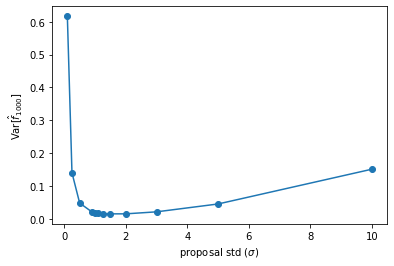

In [80]:
plt.plot(np.sqrt(np.array(proposal_variances)), estimator_variances, '-o')
plt.xlabel("proposal std ($\\sigma$)")
plt.ylabel("Var[$\hat{{f}}_{{ {} }}$]".format(num_steps))

# Compare to vanilla Monte Carlo
What is the variance of the vanilla Monte Carlo estimator?

\begin{align}
\hat{f}_{\mathsf{MC}} = \frac{1}{N} \sum_{n=1}^N f(x_n) \qquad x_n \sim p
\end{align}

For $f(x) = \sum_{d=1}^D x_d$ with $x \sim \mathcal{N}(0, I)$, 
\begin{align}
\mathrm{Var}[f(x)] = \sum_{d=1}^D \mathrm{Var}(x_d) = D 
\end{align}

Then
\begin{align}
\mathrm{Var}[\hat{f}_{\mathsf{MC}}] &= \frac{1}{N^2} \sum_{n=1}^N \mathrm{Var}[f(x)] \\
&= \frac{ND}{N^2} = \frac{D}{N}
\end{align}

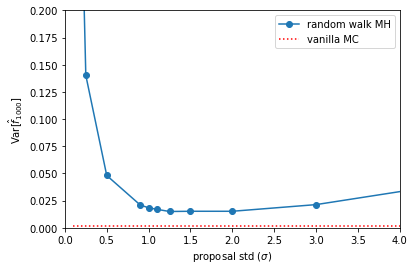

In [83]:
plt.plot(np.sqrt(np.array(proposal_variances)), estimator_variances, 
         '-o', label="random walk MH")
plt.plot(np.sqrt(np.array(proposal_variances)), 
         dim / num_steps * np.ones_like(proposal_variances), 
         ':r', label="vanilla MC")
plt.xlim(0, 4)
plt.xlabel("proposal std ($\\sigma$)")
plt.ylim(0, 0.2)
plt.ylabel("Var[$\hat{{f}}_{{ {} }}$]".format(num_steps))
plt.legend(loc="upper right")